Imagine a scenario where a company intends to train your model using the same dataset. However, there is a dishonest employee within the company who gains access to your training code. This employee proceeds to alter the code by manipulating the labels in the training samples. For instance, in your dataset X_train and y_train, the employee flips the labels stored in the variable y_train to sabotage your training process. The consequence of such manipulation is that the images and their corresponding labels no longer match. For example, if your cassava leaf image originally corresponds to 'mosaic_disease', due to the manipulated labels, it would now be labeled as 'healthy'. One method to manipulate the labels involves taking a label and randomly replacing it with another label which is also called random label flipping. Another method can be replacing all labels with only specific label.

# 1. You are required to provide functional code for manipulating the labels in your training set and observing its impact on the performance of the model developed in part A. You must compare the performance of the model before and after such label manipulation across various percentages of flipped labels in the training samples for your neural network model. For example, rather than manipulating all labels, manipulate a certain percentage of labels (5%, 10%, 15%, and so on) and graphically observe the impact on the training process's performance. While you could use a simple strategy like random label flipping for your analysis, higher marks will be awarded if you can propose a better optimal strategy. The objective of your label manipulation strategy should be to minimize the number of manipulated labels in the training data while achieving the maximum drop in model performance. Think like an intruder. (15 marks)¶

Let's start by implementing the label manipulation function

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random


In [4]:
#import os
#Dir = 'C:/Users/tao130/Downloads/cassava-leaf-disease-classification'
#os.listdir(Dir)

In [5]:
#print(len(os.listdir('C:/Users/tao130/Downloads/cassava-leaf-disease-classification')))

In [6]:
#print(len(os.listdir('C:/Users/tao130/Downloads/cassava-leaf-disease-classification')))

# Load and preprocess the dataset.

In [18]:
train_data = pd.read_csv('C:/Users/BABATUNDE/Downloads/cassava-leaf-disease-classification/train.csv')
train_data.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [19]:


# Define load_data function to load your dataset
def load_data():
    train_data = pd.read_csv('C:/Users/BABATUNDE/Downloads/cassava-leaf-disease-classification/train.csv')
    print(train_data.head())  # Display head of the dataset
    return train_data


In [17]:
# Define preprocess_data function to preprocess your dataset
def preprocess_data(train_data):
    # Preprocess your dataset here
    # Example:
    # Load images and resize them
    train_image_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2  # Split data into training and validation sets
    )

In [30]:
def preprocess_data(train_data):
    # Perform preprocessing steps here
    # Example:
    train_generator = train_image_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='C:/Users/BABATUNDE/Downloads/cassava-leaf-disease-classification/train_images',
        x_col='image_id',
        y_col='label',
        target_size=(300, 300),
        batch_size=16,
        class_mode='categorical',
        subset='training'
    )
    val_generator = train_image_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='C:/Users/BABATUNDE/Downloads/cassava-leaf-disease-classification/train_images',
        x_col='image_id',
        y_col='label',
        target_size=(300, 300),
        batch_size=16,
        class_mode='categorical',
        subset='validation'
    )
    return train_generator, val_generator


In [31]:
Batch_size = 16
img_height, img_width = 300, 300

In [32]:
train_data['label'] = train_data['label'].astype('str')
gen = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    validation_split = 0.2,
)

train_datagen = gen.flow_from_dataframe(
    train_data,
 directory='C:/Users/BABATUNDE/Downloads/cassava-leaf-disease-classification/train_images',
    batch_size = Batch_size,
    target_size = (img_height, img_width),
    subset = "training",
    seed = 42,
    x_col = "image_id",
    y_col = "label",
    class_mode = "categorical"
)

Found 620 validated image filenames belonging to 5 classes.


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 20622 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


In [33]:
val_gen = ImageDataGenerator(
    validation_split = 0.2
)

val_datagen = val_gen.flow_from_dataframe(
    train_data,
  directory='C:/Users/BABATUNDE/Downloads/cassava-leaf-disease-classification/train_images',
    batch_size = Batch_size,
    target_size = (img_height, img_width),
    subset = "validation",
    seed = 42,
    x_col = "image_id",
    y_col = "label",
    class_mode = "categorical"
)

Found 155 validated image filenames belonging to 5 classes.


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 20622 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


In [34]:
# Define model architecture
def create_model(input_shape=(300, 300, 3)):
    model = models.Sequential()
    model.add(EfficientNetB3(include_top=False, weights='imagenet', input_shape=input_shape, drop_connect_rate=0.3))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(5, activation='softmax'))
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.0001, name='categorical_crossentropy')
    optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
    return model# Define model architecture


In [35]:
# Define function for label manipulation
def flip_labels(labels, flip_percentage):
    flipped_labels = labels.copy()
    num_flips = int(len(labels) * flip_percentage / 100)
    flip_indices = random.sample(range(len(labels)), num_flips)
    for idx in flip_indices:
        current_label = flipped_labels[idx]
        possible_labels = [label for label in range(5) if label != current_label]
        flipped_labels[idx] = random.choice(possible_labels)
    return flipped_labels

In [38]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation parameters
train_image_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Define preprocess_data function
def preprocess_data(train_data):
    # Perform preprocessing steps here
    # Example:
    train_generator = train_image_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='C:/Users/BABATUNDE/Downloads/cassava-leaf-disease-classification/train_images',
        x_col='image_id',
        y_col='label',
        target_size=(300, 300),
        batch_size=16,
        class_mode='categorical',
        subset='training'
    )
    val_generator = train_image_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='C:/Users/BABATUNDE/Downloads/cassava-leaf-disease-classification/train_images',
        x_col='image_id',
        y_col='label',
        target_size=(300, 300),
        batch_size=16,
        class_mode='categorical',
        subset='validation'
    )
    return train_generator, val_generator

# Load and preprocess data
train_data = pd.read_csv('C:/Users/BABATUNDE/Downloads/cassava-leaf-disease-classification/train.csv')  # Load your DataFrame from the CSV file
train_data['label'] = train_data['label'].astype(str)  # Convert label column to string type
train_generator, val_generator = preprocess_data(train_data)

# Train the model with original data
# Assuming this function is defined elsewhere
# model_before = create_model()


Found 775 validated image filenames belonging to 5 classes.


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 20622 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


Found 0 validated image filenames belonging to 5 classes.


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 20622 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


In [39]:

# Define training parameters
epochs = 5
batch_size = 16


# Train the model with original data
model_before = create_model()
history_before = model_before.fit(train_generator, epochs=epochs, validation_data=val_generator)

# Define list of percentages of flipped labels to test
flip_percentages = [5, 10, 15, 20]

# Dictionary to store accuracy results
accuracy_results = {}



43941136/43941136 [==============================] - 2s 0us/step
Epoch 1/5


49/49 [==============================] - 228s 4s/step - loss: 1.1707 - accuracy: 0.5652
Epoch 2/5
49/49 [==============================] - 176s 4s/step - loss: 0.8334 - accuracy: 0.6981
Epoch 3/5
49/49 [==============================] - 176s 4s/step - loss: 0.6504 - accuracy: 0.7729
Epoch 4/5
49/49 [==============================] - 176s 4s/step - loss: 0.5329 - accuracy: 0.8194
Epoch 5/5
49/49 [==============================] - 175s 4s/step - loss: 0.4245 - accuracy: 0.8452


In [43]:
y_train = train_data['label']
X_train = train_data['image_id']


In [45]:
print(type(X_train))
print(type(flipped_labels))


<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


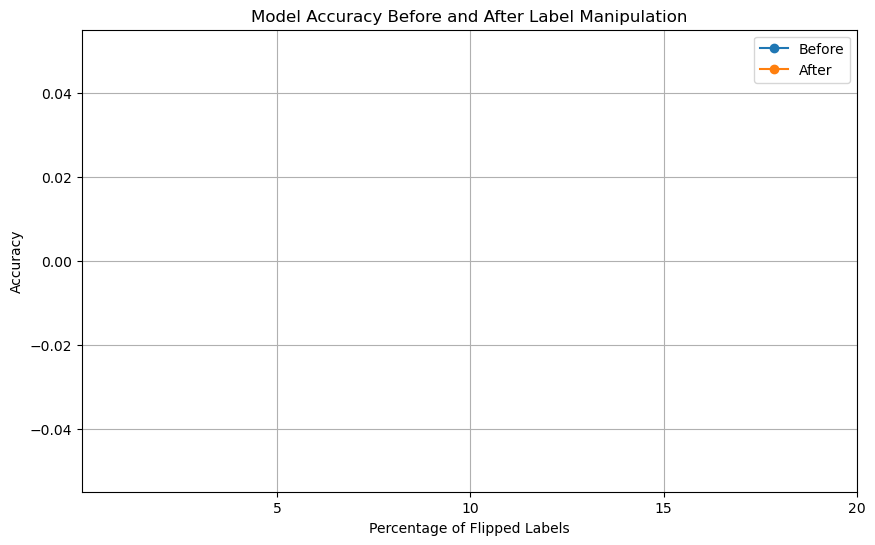

In [61]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(accuracy_results.keys(), [result['before'] for result in accuracy_results.values()], marker='o', label='Before')
plt.plot(accuracy_results.keys(), [result['after'] for result in accuracy_results.values()], marker='o', label='After')
plt.title('Model Accuracy Before and After Label Manipulation')
plt.xlabel('Percentage of Flipped Labels')
plt.ylabel('Accuracy')
plt.xticks(flip_percentages)
plt.legend()
plt.grid(True)
plt.show()